# Lesson 9: Final Decisions

## Intro to Quantified Cognition

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2021_Spring/notebooks/09_Final_Decisions.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- Wiener First Passage of Time
- Timed Racing Diffusion Model
- Posterior Exploration
- Model Comparison


## Example: Speed--Accuracy trade-off

- Sometimes we have to make fast decisions
- Other times we just need to be as accurate as possible.

## If running locally with Anaconda

In [ ]:
# install numba (using anaconda)
!conda install numba

## *ONLY* if on Google Colab

In [ ]:
# install numba (use pip on Colab)
!pip install numba

In [ ]:
# to install RunDEMC
!pip install git+https://github.com/compmem/RunDEMC.git --upgrade


In [ ]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/2021_Spring/notebooks/decision_data.csv

In [ ]:
# to retrieve the wfpt and trdm models
!wget https://raw.githubusercontent.com/compmem/QuantCog/2021_Spring/notebooks/wfpt.py
!wget https://raw.githubusercontent.com/compmem/QuantCog/2021_Spring/notebooks/nu_wfpt.py
!wget https://raw.githubusercontent.com/compmem/QuantCog/2021_Spring/notebooks/wald_race.py

## Load and process the data

In [1]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

from ipywidgets import interact, fixed

import arviz as az

from RunDEMC.density import kdensity
from RunDEMC import Model, Param, dists
from RunDEMC import DE, calc_bpic, joint_plot
from RunDEMC.io import arviz_dict

from nu_wfpt import wfpt_like, wfpt_gen
from waldrace import trdm_like, trdm_gen



In [2]:
# load in the data
dat = pd.read_csv('decision_data.csv', index_col=0)
dat = dat[dat.cond != 'Neutral']
dat['rt_acc'] = dat['rt']
dat.loc[dat.correct==0,'rt_acc'] = -dat['rt']
dat.head()

,correct,rt,cond,log_rt,rt_acc
3,1,0.4784,Accuracy,-0.737308,0.4784
4,1,0.4300,Accuracy,-0.843970,0.4300
5,1,0.4486,Accuracy,-0.801624,0.4486
6,1,0.3991,Speed,-0.918543,0.3991
8,1,0.4393,Accuracy,-0.822573,0.4393


## Wiener First Passage of Time (WFPT)

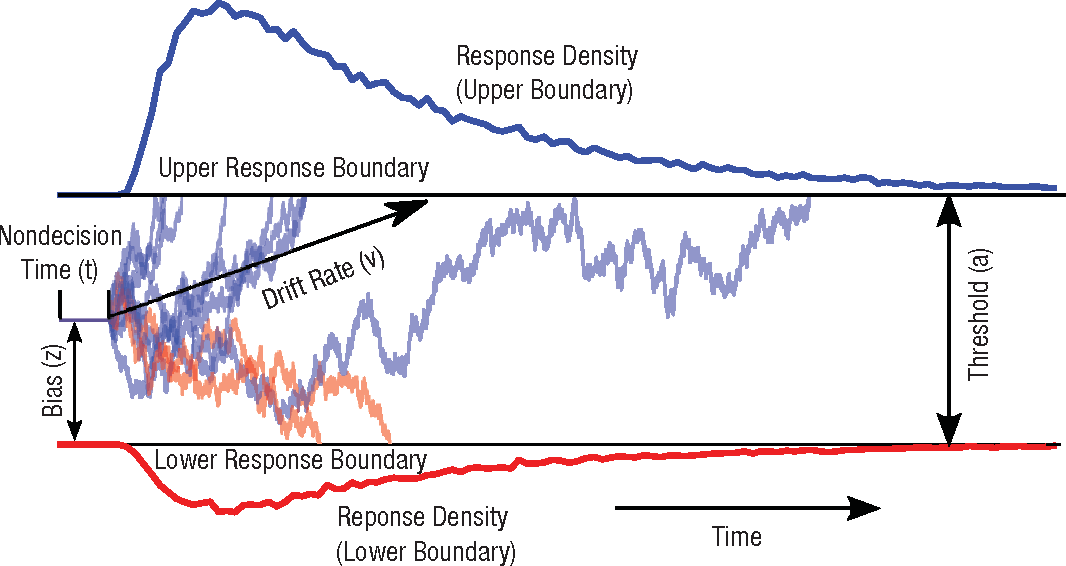


In [3]:
# set up the sim
nsims = 5000
cond='Accuracy'

# normed histogram
def dhist(dat, nvals, alpha=.3, color='b'):
    p,b = np.histogram(dat, bins='auto', density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nvals
    return plt.bar(b[1:]-w, p, width=w, alpha=.3, color=color)

# normed pdf
xvals = np.linspace(0.0,2.0,1000)

# put it all together
@interact(cond=['Accuracy', 'Speed'],
          v_mean=(-5,5.0,0.05),
          v_std=(0.0,5.0,0.05),
          a=(0.0,5.0,.05),
          w_mode=(0.0,1.0,.05),
          w_std=(0.0,1.0,.02),
          t0=(0.0,1.0,.02),
          S=fixed(1.0),
          nsamp=fixed(2000),
          err=fixed(.0001)
          )
def run_wfpt(cond, v_mean=1.75, a=1.5, w_mode=.5, w_std=0.0,
             v_std=0.0, t0=0.0, nsamp=5000, err=.0001):

    ndat = (dat['cond']==cond).sum()
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    likes = wfpt_like(np.ones(len(xvals))*2, xvals, v_mean, a, w_mode, w_std=w_std,
                      v_std=v_std, t0=0, nsamp=nsamp, err=err)
    plt.plot(xvals+t0, likes, color='b', lw=2.)
    
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    likes = wfpt_like(np.ones(len(xvals))*1, xvals, v_mean, a, w_mode, w_std=w_std,
                      v_std=v_std, t0=0, nsamp=nsamp, err=err)
    plt.plot(xvals+t0, likes, color='r', lw=2.)
    #ylim(0,5.0)
    plt.xlim(0,2.0)

interactive(children=(Dropdown(description='cond', options=('Accuracy', 'Speed'), value='Accuracy'), FloatSlid…

## Using computers to test hypotheses

In [4]:
# grab the beh data of interest
choices_A = np.array(dat[(dat['cond']=='Accuracy')]['correct']+1)
rts_A = np.array(dat[(dat['cond']=='Accuracy')]['rt'])
choices_S = np.array(dat[(dat['cond']=='Speed')]['correct']+1)
rts_S = np.array(dat[(dat['cond']=='Speed')]['rt'])
min_rt = dat.rt.min()

In [86]:
# Test change in threshold and drift rate

# set up the params
params = [Param(name='v_A', prior=dists.normal(0., 2.)),
          Param(name='v_S', prior=dists.normal(0., 2.)),
          Param(name='w', prior=dists.normal(0, 1.4), transform=dists.invlogit),
          Param(name='a_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='a_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]
param_names = [p.name for p in params]

# define the likelihood function
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first Accuracy
        likes_A = wfpt_like(choices_A, rts_A, 
                            v_mean=p['v_A'], v_std=0.0, a=p['a_A'], 
                            w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                            nsamp=1000)
        likes[i] += np.log(likes_A).sum()
        if likes[i] == -np.inf:
            continue
            
        # then Speed
        likes_S = wfpt_like(choices_S, rts_S, 
                            v_mean=p['v_S'], v_std=0.0, a=p['a_S'], 
                            w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                            nsamp=1000)
        likes[i] += np.log(likes_S).sum()

    return likes

       
# make the model
m = Model('wfpt', params=params,
          like_fun=like_fun,
          pop_parallel=True,
          #num_chains=120,
          #like_args=(param_names,),
          #purify_every=5,
          verbose=True)


In [87]:
# do some burnin
times = m.sample(100, burnin=True)

Initializing: 60(60) 2(2) Iterations (100):


In [88]:
# sample from the posterior
times = m.sample(500, burnin=False)

Iterations (500):


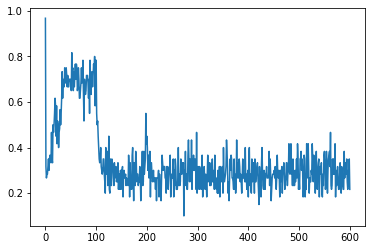

In [89]:
plt.plot(m.accept_rate)

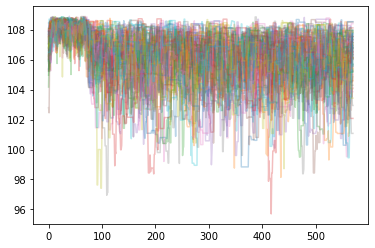

In [90]:
plt.plot(m.weights[30:], alpha=0.3);

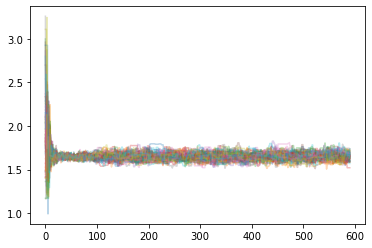

In [91]:
plt.plot(m.particles[10:, :, 3], alpha=0.3);

In [92]:
print("Best fitting params:")
burnin=200
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] 
         for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: 108.84129467286385
"v_A": 2.126595,
"v_S": 1.627442,
"w": 0.357092,
"a_A": 1.635886,
"a_S": 0.905269,
"t0": 0.202461,


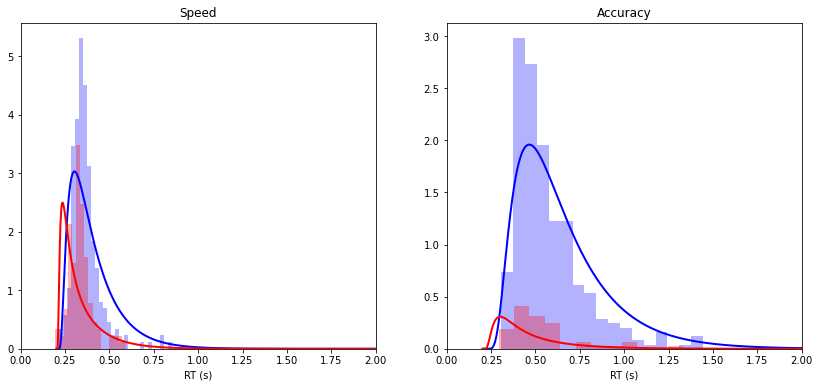

In [93]:
# set up new figure
plt.figure(figsize=(14,6))

# try different params!
plt.subplot(1,2,1)
cond='Speed'
run_wfpt(cond, v_mean=pp['v_S'], a=pp['a_S'], w_mode=pp['w'], t0=pp['t0'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

plt.subplot(1,2,2)
cond='Accuracy'
run_wfpt(cond, v_mean=pp['v_A'], a=pp['a_A'], w_mode=pp['w'], t0=pp['t0'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);


## Exploring the posterior

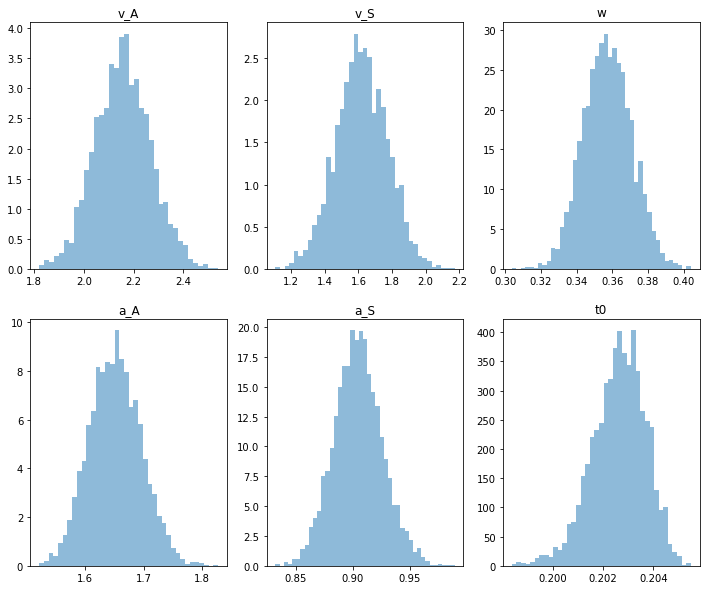

In [94]:
plt.figure(figsize=(12,10))
burnin=200
for i in range(len(params)):
    plt.subplot(2,3,i+1)
    plt.hist(m.particles[burnin:, :, i].flatten()[::7], bins='auto', alpha=.5, density=True);
    plt.title(m.param_names[i])

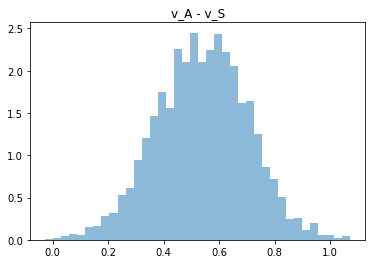

In [96]:
# compare the drift rates
i = 0
j = 1
plt.hist((m.particles[burnin:, :, i].flatten() - 
          m.particles[burnin:, :, j].flatten())[::7],
         bins='auto', alpha=.5, density=True);
plt.title(m.param_names[i] + ' - ' + m.param_names[j]);

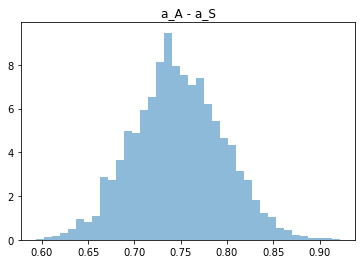

In [97]:
# compare the thresholds
i = 3
j = 4
plt.hist((m.particles[burnin:, :, i].flatten() - 
          m.particles[burnin:, :, j].flatten())[::7],
         bins='auto', alpha=.5, density=True);
plt.title(m.param_names[i] + ' - ' + m.param_names[j]);

In [98]:
# save out model to an ArviZ Inference Dataset
daz_w = az.from_dict(**arviz_dict(m, burnin=200))
daz_w.posterior

<xarray.Dataset>
Dimensions:  (chain: 60, draw: 401)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
Data variables:
    v_A      (chain, draw) float64 2.021 2.021 2.021 1.99 ... 2.15 2.26 2.305
    v_S      (chain, draw) float64 1.996 1.996 1.996 2.013 ... 1.423 1.581 1.571
    w        (chain, draw) float64 0.3448 0.3448 0.3448 ... 0.3681 0.366 0.3568
    a_A      (chain, draw) float64 1.638 1.638 1.638 1.604 ... 1.625 1.669 1.697
    a_S      (chain, draw) float64 0.8892 0.8892 0.8892 ... 0.8906 0.8957 0.8891
    t0       (chain, draw) float64 0.2032 0.2032 0.2032 ... 0.2043 0.204 0.2037
Attributes:
    created_at:     2021-04-01T16:58:21.476557
    arviz_version:  0.10.0

In [99]:
az.summary(daz_w)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v_A,2.155,0.113,1.945,2.370,0.003,0.002,1307.0,1285.0,1319.0,1548.0,1.04
v_S,1.621,0.153,1.325,1.893,0.006,0.004,731.0,731.0,731.0,1823.0,1.06
w,0.357,0.014,0.332,0.382,0.000,0.000,1195.0,1190.0,1198.0,1732.0,1.04
a_A,1.652,0.044,1.574,1.736,0.001,0.001,1429.0,1424.0,1441.0,2322.0,1.04
a_S,0.905,0.021,0.862,0.943,0.001,0.001,835.0,829.0,848.0,1805.0,1.05
t0,0.203,0.001,0.201,0.205,0.000,0.000,1205.0,1201.0,1104.0,1442.0,1.04


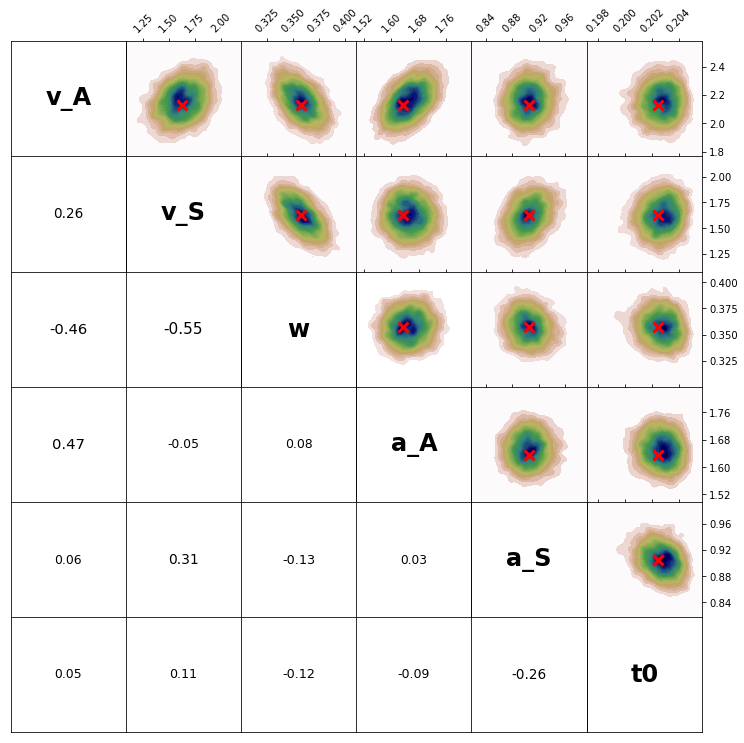

In [100]:
plt.figure(figsize=(12,12))

burnin = 200
joint_plot(m.particles, m.weights, burnin=burnin, 
           names=m.param_display_names, rot=45);

array([<AxesSubplot:title={'center':'a_S'}>,
       <AxesSubplot:title={'center':'a_A'}>], dtype=object)

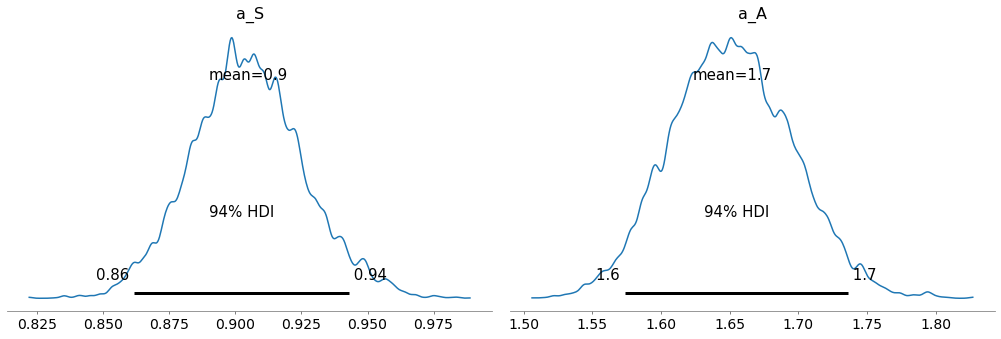

In [101]:
az.plot_posterior(daz_w, var_names=['a_S', 'a_A'])

In [102]:
# save results out to file
daz_w.to_netcdf('09_wfpt_results.nc')

'09_wfpt_results.nc'

In [103]:
# show how to read it back in
daz_w2 = az.from_netcdf('09_wfpt_results.nc')
daz_w2.posterior

<xarray.Dataset>
Dimensions:  (chain: 60, draw: 401)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
Data variables:
    v_A      (chain, draw) float64 ...
    v_S      (chain, draw) float64 ...
    w        (chain, draw) float64 ...
    a_A      (chain, draw) float64 ...
    a_S      (chain, draw) float64 ...
    t0       (chain, draw) float64 ...
Attributes:
    created_at:     2021-04-01T16:58:21.476557
    arviz_version:  0.10.0

## Timed Racing Diffusion Model (TRDM; Hawkins & Heathcote, 2021)

![](./figs/Hawkins_Heathcote_TRDM.png)

In [104]:
# set up the sim
cond='Accuracy'

# normed histogram
def dhist(dat, nvals, alpha=.3, color='b'):
    p,b = np.histogram(dat, bins='auto', density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nvals
    return plt.bar(b[1:]-w, p, width=w, alpha=.3, color=color)

# normed pdf
xvals = np.linspace(0.0,2.0,1000)

# put it all together
@interact(cond=['Accuracy', 'Speed'],
          v_1=(0,5.0,0.05),
          v_2=(0,5.0,0.05),
          v_t=(0,5.0,0.05),
          theta=(0.0,0.5,.01),
          sig=(0.0,2.0,.05),
          sig_t=(0.0,4.0,.02),
          rho=(0.0,1.0,.02),
          )
def run_trdm(cond, v_1=0.25, v_2=0.75, v_t=0.1, theta=0.0,
             sig=1.0, sig_t=0.5, rho=0.0):

    ndat = (dat['cond']==cond).sum()
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    likes = trdm_like(np.ones(len(xvals))*2, xvals, 
                      v=[v_1, v_2, v_t], alpha=1.0, theta=theta,
                      sig=[sig, sig, sig_t], rho=rho)
    plt.plot(xvals, likes, color='b', lw=2.)
    
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    likes = trdm_like(np.ones(len(xvals))*1, xvals, 
                      v=[v_1, v_2, v_t], alpha=1.0, theta=theta,
                      sig=[sig, sig, sig_t], rho=rho)
    plt.plot(xvals, likes, color='r', lw=2.)
    #ylim(0,5.0)
    plt.xlim(0,2.0)

interactive(children=(Dropdown(description='cond', options=('Accuracy', 'Speed'), value='Accuracy'), FloatSlid…

In [117]:
# Test change in timer

# set up the params
params = [Param(name='v1', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='v2', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='vt_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='vt_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='sig', prior=dists.halfcauchy(5.0)),
          Param(name='sig_t', prior=dists.halfcauchy(5.0)),
          Param(name='rho', prior=dists.normal(0, 1.4),
                transform=dists.invlogit),
          #Param(name='rho', prior=0.0),
          Param(name='t0', prior=dists.normal(0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]
param_names = [p.name for p in params]

# define the likelihood function
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first Accuracy
        likes_A = trdm_like(choices_A, rts_A, 
                            v=[p['v1'], p['v2'], p['vt_A']], 
                            alpha=1.0, 
                            theta=p['t0'],
                            sig=[p['sig'], p['sig'], p['sig_t']], 
                            rho=p['rho'])
        likes[i] += np.log(likes_A).sum()
        if likes[i] == -np.inf:
            continue
            
        # then Speed
        likes_S = trdm_like(choices_S, rts_S, 
                            v=[p['v1'], p['v2'], p['vt_S']], 
                            alpha=1.0, 
                            theta=p['t0'],
                            sig=[p['sig'], p['sig'], p['sig_t']], 
                            rho=p['rho'])
        likes[i] += np.log(likes_S).sum()

    return likes

       
# make the model
m = Model('trdm', params=params,
          like_fun=like_fun,
          pop_parallel=True,
          #num_chains=120,
          #like_args=(param_names,),
          #purify_every=5,
          verbose=True)


In [118]:
# do some burnin
times = m.sample(100, burnin=True)

Initializing: 80(80) 5(5) Iterations (100):


In [119]:
# sample from the posterior
times = m.sample(500, burnin=False)

Iterations (500):


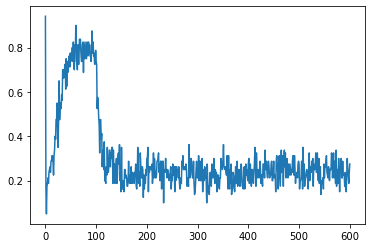

In [120]:
plt.plot(m.accept_rate)

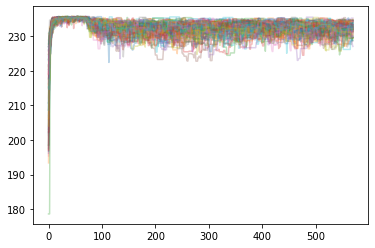

In [121]:
plt.plot(m.weights[30:], alpha=0.3);

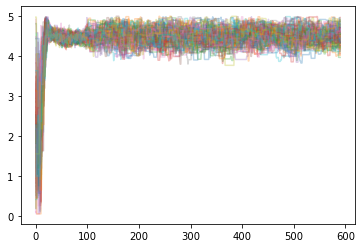

In [122]:
plt.plot(m.particles[10:, :, 3], alpha=0.3);

In [123]:
print("Best fitting params:")
burnin=200
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] 
         for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: 235.547592530297
"v1": 0.207142,
"v2": 1.903040,
"vt_A": 1.039738,
"vt_S": 4.446184,
"sig": 0.600851,
"sig_t": 0.745968,
"rho": 0.464529,
"t0": 0.148498,


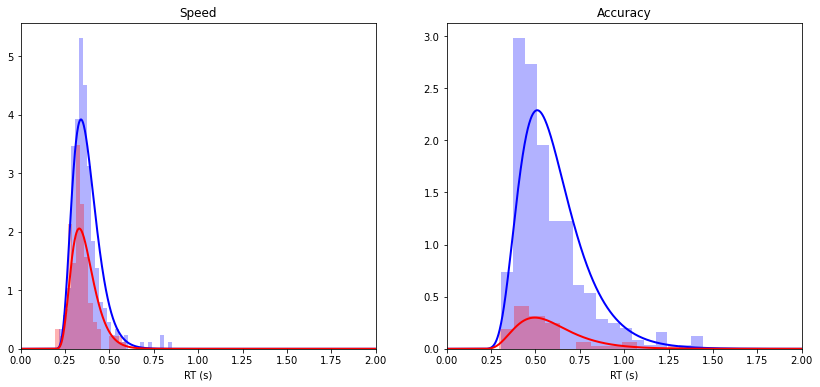

In [124]:
# set up new figure
plt.figure(figsize=(14,6))

# try different params!
plt.subplot(1,2,1)
cond='Speed'
run_trdm(cond, v_1=pp['v1'], v_2=pp['v2'], v_t=pp['vt_S'],
         theta=pp['t0'], sig=pp['sig'], sig_t=pp['sig_t'], rho=pp['rho'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

plt.subplot(1,2,2)
cond='Accuracy'
run_trdm(cond, v_1=pp['v1'], v_2=pp['v2'], v_t=pp['vt_A'],
         theta=pp['t0'], sig=pp['sig'], sig_t=pp['sig_t'], rho=pp['rho'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);


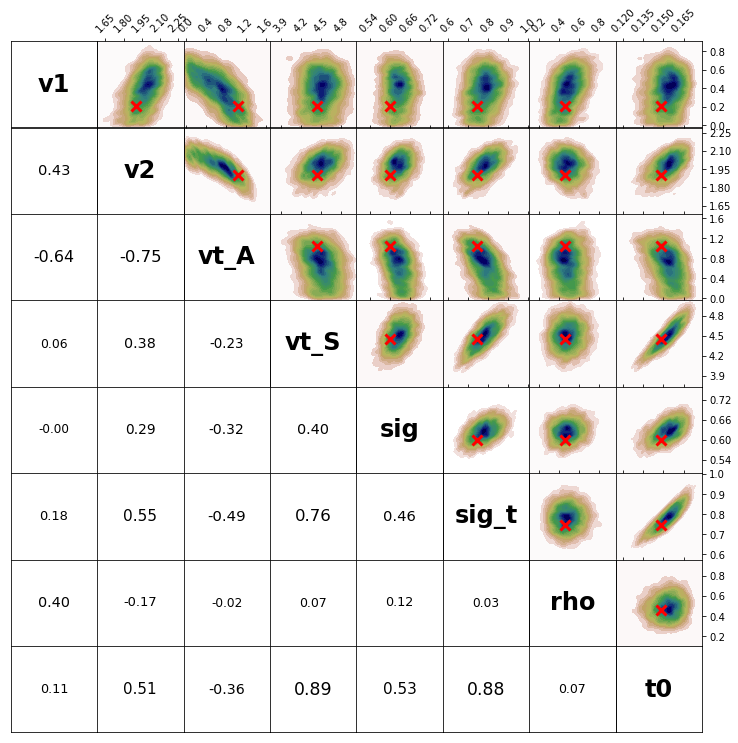

In [125]:
plt.figure(figsize=(12,12))

burnin = 200
joint_plot(m.particles, m.weights, burnin=burnin, 
           names=m.param_display_names, rot=45);

In [126]:
# save out model to an ArviZ Inference Dataset
daz_t = az.from_dict(**arviz_dict(m, burnin=200))
daz_t.posterior

<xarray.Dataset>
Dimensions:  (chain: 80, draw: 401)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 70 71 72 73 74 75 76 77 78 79
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
Data variables:
    v1       (chain, draw) float64 0.5727 0.5727 0.6961 ... 0.6021 0.6021 0.4202
    v2       (chain, draw) float64 2.083 2.083 2.101 2.101 ... 2.125 2.125 2.032
    vt_A     (chain, draw) float64 0.6805 0.6805 0.4607 ... 0.3848 0.3848 0.6853
    vt_S     (chain, draw) float64 4.325 4.325 4.417 4.417 ... 4.956 4.956 4.762
    sig      (chain, draw) float64 0.6326 0.6326 0.6225 ... 0.6214 0.6214 0.6161
    sig_t    (chain, draw) float64 0.718 0.718 0.7386 ... 0.8894 0.8894 0.7871
    rho      (chain, draw) float64 0.3159 0.3159 0.3021 ... 0.545 0.545 0.4948
    t0       (chain, draw) float64 0.1492 0.1492 0.1534 ... 0.1683 0.1683 0.1595
Attributes:
    created_at:     2021-04-01T17:10:06.514485
    arviz_version:  0.10.0

In [127]:
az.summary(daz_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v1,0.378,0.188,0.002,0.659,0.007,0.005,703.0,703.0,720.0,1398.0,1.09
v2,1.972,0.097,1.797,2.158,0.004,0.003,521.0,521.0,535.0,874.0,1.10
vt_A,0.661,0.340,0.003,1.173,0.014,0.010,587.0,587.0,568.0,798.0,1.10
vt_S,4.496,0.200,4.131,4.880,0.007,0.005,794.0,794.0,793.0,2000.0,1.07
sig,0.625,0.030,0.571,0.683,0.001,0.001,872.0,872.0,873.0,1334.0,1.07
sig_t,0.781,0.060,0.671,0.895,0.002,0.002,796.0,794.0,800.0,1511.0,1.08
rho,0.486,0.114,0.279,0.699,0.004,0.003,721.0,712.0,725.0,1284.0,1.08
t0,0.152,0.009,0.135,0.169,0.000,0.000,761.0,757.0,758.0,1790.0,1.08


In [129]:
# save results out to file
daz_t.to_netcdf('09_trdm_results.nc')

'09_trdm_results.nc'

## Model comparison with BPIC (Ando, 2007)

Lower is better!!!

In [130]:
print('TRDM:',calc_bpic(daz_t.log_likelihood['trdm'].values)['bpic'])
print('WFPT:',calc_bpic(daz_w.log_likelihood['wfpt'].values)['bpic'])

TRDM: -450.71637053056656
WFPT: -200.754970056384


## The nature of the accumulation process (Kirkpatrick et al., 2021)

![](./figs/accumulators.png)